### Реализация алгоритма Squarified TreeMap, описанного в статье https://www.win.tue.nl/~vanwijk/stm.pdf

В ноутбуке код для

- squarification - жадный алгоритм, задача которого заключается в приближении ячеек к более квадратным, чем в оригинальном TreeMap
- создание датасета на основе данных из файловой системы
- построение полной диаграммы для полученного датасета со вложенными подкатегориями

Результатом запуска всего ноутбука будет картинка result.png - требуемая диаграмма.

P.S. Во всех ячейках, где указано ```path = "<path>"```, нужно заменить ```<path>``` на реальный путь в файловой системе.

In [23]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [24]:
def worst(children_areas, w):
    """
    Возвращает самое большое соотношение сторон для списка прямоугольников
    w - длина строрны, вдоль которой располагаются прямоугольники
    """    
    max_area = children_areas[0]
    min_area = children_areas[-1]
    total_sum = sum(children_areas)
    return max(w ** 2 * max_area / (total_sum ** 2), 
              (total_sum ** 2)/ (w ** 2 * min_area))


rectangles = []

def layout_row(row, x1, y1, x2, y2):
    """
    row - список площадей дочерних прямоугольников в этой строке
    x1, y1, x2, y2 - координаты прямоугольника, в который вкладываются дочерние прямоугольники
    Возвращает координаты нового прямоугольника, с которым нужно теперь работать
    """
    global rectangles
    width = x2 - x1
    height = y2 - y1
    
    total_area = sum(row)
    
    if width < height:
        # Укладываем в горизонтальную строку (слева направо снизу)
        row_height = total_area / width 
        
        x_prev_max = x1
        
        for rec in row:
            cur_y1 = y1
            cur_y2 = y1 + row_height
            
            cur_x1 = x_prev_max
            cur_x2 = cur_x1 + (rec / row_height)
            
            rectangles.append((cur_x1, cur_y1, cur_x2, cur_y2))
            x_prev_max = cur_x2
            
        return (x1, y1 + row_height, x2, y2)
        
    else:
        # Укладываем в вертикальную строку (снизу вверх слева)
        row_width = total_area / height
        
        y_prev_max = y1
        
        for rec in row:
            cur_x1 = x1
            cur_x2 = x1 + row_width
            
            cur_y1 = y_prev_max
            cur_y2 = cur_y1 + (rec / row_width)
            
            rectangles.append((cur_x1, cur_y1, cur_x2, cur_y2))
            y_prev_max = cur_y2
            
        return (x1 + row_width, y1, x2, y2)
    

def shortest_side(x1, y1, x2, y2):
    width = x2 - x1
    height = y2 - y1
    return width if width < height else height
    
    
def squarify(children_areas, current_row, smallest_side, big_rectangle_coords):
    global rectangles
    
    if len(current_row) == 0:
        
        if len(children_areas) == 1:
            # Других вариантов нет, просто добавляем
            big_rectangle_coords = layout_row(children_areas, *big_rectangle_coords)
            return
        
        else:
            squarify(children_areas[1:], [children_areas[0]], smallest_side, big_rectangle_coords)
            return 
    
    if len(children_areas) == 0:
        
        if len(current_row) != 0:
            big_rectangle_coords = layout_row(current_row, *big_rectangle_coords)
        return 
    
    # Считаем что список площадей children_areas отсортирован по убыванию
    c = children_areas[0]
    
    if worst(current_row, smallest_side) > worst(current_row + [c], smallest_side):
        squarify(children_areas[1:], current_row + [c], smallest_side, big_rectangle_coords)
    else:
        # меняются координаты прямоугольника
        big_rectangle_coords = layout_row(current_row, *big_rectangle_coords)
        
        squarify(children_areas, [], shortest_side(*big_rectangle_coords), big_rectangle_coords)
        
    return

In [25]:
rectangles = []
squarify([6, 6, 4, 3, 2, 2, 1], [], 4, (0, 0, 6, 4))

In [26]:
rectangles

[(0, 0, 3.0, 2.0),
 (0, 2.0, 3.0, 4.0),
 (3.0, 0, 4.714285714285714, 2.3333333333333335),
 (4.714285714285714, 0, 6.0, 2.3333333333333335),
 (3.0, 2.3333333333333335, 4.2, 4.0),
 (4.2, 2.3333333333333335, 5.4, 4.0),
 (5.4, 2.3333333333333335, 6.0, 4.000000000000001)]

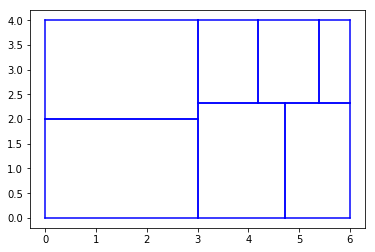

In [27]:
for rec in rectangles:
    
    plt.plot([rec[0], rec[2]], [rec[1], rec[1]], color='blue')  # горизонтальная линия внизу
    plt.plot([rec[0], rec[2]], [rec[3], rec[3]], color='blue')  # горизонтальная линия сверху
    plt.plot([rec[0], rec[0]], [rec[1], rec[3]], color='blue')  # вертикальная линия слева
    plt.plot([rec[2], rec[2]], [rec[1], rec[3]], color='blue')  # вертикальная линия справа
    
#     plt.text((rec[2] - rec[0]) / 2 + rec[0], (rec[3] - rec[1]) / 2 + rec[1],
#              'text', color='black')
    
plt.show()

### Создадим датасет - данные из файловой системы

In [6]:
import os

In [7]:
def recursively_walk(path, files_rec, sum_size):
    
    if os.path.isfile(path):
        
        size = os.path.getsize(path)
        files_rec.append((size, os.path.split(path)[-1]))
        files_rec.append((os.path.split(path)[-1], size))
        sum_size += size
        return files_rec[0], sum_size
    else:
        files_and_dirs_inside = os.listdir(path)
        
        if len(files_and_dirs_inside) == 0:
            return None, sum_size
        
        for f in files_and_dirs_inside:
            new_files, sum_size = recursively_walk(os.path.join(path, f), [], sum_size)
            if new_files is not None:
                files_rec.append(new_files)

        return files_rec, sum_size
        

In [8]:
path = "<path>"
dataset, sum_size = recursively_walk(path, [], 0)

In [9]:
dataset

[[(90792, 'squarified_treemap-checkpoint.ipynb')],
 (40457, 'result.png'),
 (3364352, 'Sample - Superstore.xls'),
 (92851, 'squarified_treemap.ipynb')]

In [10]:
sum_size

3588452

### Tree Map

In [11]:
def get_list_total_size(l, total_size):
    
    if type(l) is not list:
        return l[0]
    
    total_size = 0
    
    for elem in l:
        if type(elem) is not list:
            total_size += elem[0]
        else:
            total_size = total_size + get_list_total_size(elem, total_size)
            
    return total_size
    

In [12]:
get_list_total_size([[(1, 'a')]], 0)

1

In [13]:
get_list_total_size([[(1, 'a'), (2, 'b')], (3, 'c')], 0)

6

In [14]:
get_list_total_size(dataset, 0)

3588452

In [15]:
get_list_total_size((1, 'a'), 0)

1

In [16]:
get_list_total_size(dataset, 0)

3588452

In [17]:
get_list_total_size(dataset[0], 0)

90792

In [18]:
sorted(dataset, key=lambda x: -get_list_total_size(x, 0))

[(3364352, 'Sample - Superstore.xls'),
 (92851, 'squarified_treemap.ipynb'),
 [(90792, 'squarified_treemap-checkpoint.ipynb')],
 (40457, 'result.png')]

In [19]:
def worst(children_areas, w):
    """
    Возвращает самое большое соотношение сторон для списка прямоугольников
    w - длина строрны, вдоль которой располагаются прямоугольники
    """    
    max_area = get_list_total_size(children_areas[0], 0)
    min_area = get_list_total_size(children_areas[-1], 0)

    total_sum = get_list_total_size(children_areas, 0)
    return max(w ** 2 * max_area / (total_sum ** 2), 
              (total_sum ** 2)/ (w ** 2 * min_area))


def layout_row(row, x1, y1, x2, y2):
    """
    row - список площадей дочерних прямоугольников в этой строке
    x1, y1, x2, y2 - координаты прямоугольника, в который вкладываются дочерние прямоугольники
    Возвращает координаты нового прямоугольника, с которым нужно теперь работать
    """
    global rectangles
    width = x2 - x1
    height = y2 - y1
    
    total_area = get_list_total_size(row, 0)
    
    if width < height:
        # Укладываем в горизонтальную строку (слева направо снизу)
        row_height = total_area / width 
        
        x_prev_max = x1
        
        for rec in row:
            cur_y1 = y1
            cur_y2 = y1 + row_height
            
            cur_x1 = x_prev_max
            cur_x2 = cur_x1 + (get_list_total_size(rec, 0) / row_height)
            
            coords = (cur_x1, cur_y1, cur_x2, cur_y2)
            
            if type(rec) is not list:
                rectangles.append((coords, rec[1]))
            else:
                squarify(rec, [], shortest_side(*coords), coords)
            x_prev_max = cur_x2
            
        return (x1, y1 + row_height, x2, y2)
        
    else:
        # Укладываем в вертикальную строку (снизу вверх слева)
        row_width = total_area / height
        
        y_prev_max = y1
        
        for rec in row:
            cur_x1 = x1
            cur_x2 = x1 + row_width
            
            cur_y1 = y_prev_max
            cur_y2 = cur_y1 + (get_list_total_size(rec, 0) / row_width)
            
            coords = (cur_x1, cur_y1, cur_x2, cur_y2)
            if type(rec) is not list:
                rectangles.append((coords, rec[1]))
            else:
                squarify(rec, [], shortest_side(*coords), coords)
            y_prev_max = cur_y2
            
        return (x1 + row_width, y1, x2, y2)
    

def squarify(children_areas, current_row, smallest_side, big_rectangle_coords):
    
    # отсортированная версия (по верхним уровням)
    children_areas = sorted(children_areas, key=lambda x: -get_list_total_size(x, 0))
    
    global rectangles
    
    if len(current_row) == 0:
        
        if len(children_areas) == 1:
            # Других вариантов нет, просто добавляем
            
            big_rectangle_coords = layout_row(children_areas, *big_rectangle_coords)               
                
            return
        
        else:
            squarify(children_areas[1:], [children_areas[0]], smallest_side, big_rectangle_coords)
            return 
    
    if len(children_areas) == 0:
        
        if len(current_row) != 0:
            big_rectangle_coords = layout_row(current_row, *big_rectangle_coords)
        return 
    
    # Считаем что список площадей children_areas отсортирован по убыванию
    c = children_areas[0]
    
    if worst(current_row, smallest_side) > worst(current_row + [c], smallest_side):
        squarify(children_areas[1:], current_row + [c], smallest_side, big_rectangle_coords)
    else:
        # меняются координаты прямоугольника
        big_rectangle_coords = layout_row(current_row, *big_rectangle_coords)
        
        squarify(children_areas, [], shortest_side(*big_rectangle_coords), big_rectangle_coords)
        
    return

In [20]:
def plot_rectangles(rectangles, filename_save="result.png"):
    plt.figure(figsize=(20, 20))

    for rec in rectangles:
        
        plt.plot([rec[0][0], rec[0][2]], [rec[0][1], rec[0][1]], color='blue')  # горизонтальная линия внизу
        plt.plot([rec[0][0], rec[0][2]], [rec[0][3], rec[0][3]], color='blue')  # горизонтальная линия сверху
        plt.plot([rec[0][0], rec[0][0]], [rec[0][1], rec[0][3]], color='blue')  # вертикальная линия слева
        plt.plot([rec[0][2], rec[0][2]], [rec[0][1], rec[0][3]], color='blue')  # вертикальная линия справа

        # TODO: нужно лучше центрировать
        if rec[0][2] - rec[0][0] > 1000: 
            plt.text(rec[0][0], (rec[0][3] - rec[0][1]) / 2 + rec[0][1],
                     rec[1], color='black')
        elif rec[0][2] - rec[0][0] > 600: 
            plt.text(rec[0][0], (rec[0][3] - rec[0][1]) / 2 + rec[0][1],
                     rec[1][:100] + '...', color='black')
        elif rec[0][2] - rec[0][0] > 300:
            plt.text(rec[0][0], (rec[0][3] - rec[0][1]) / 2 + rec[0][1],
                     rec[1][:18] + '...', color='black')
        else:
            plt.text(rec[0][0], (rec[0][3] - rec[0][1]) / 2 + rec[0][1],
                     '...', color='black')
            
    plt.axis('off')
    plt.savefig(filename_save, bbox_inches = 'tight')
    plt.show()

[[(47005, 'times_testing-checkpoint.ipynb')], (2487, 'design.py'), (1387, 'design.ui'), [(41235, '00a6892e5c7f92c1f465e213fd904582.jpg'), (55590, '00b43aa6064fa6733a391d41fe4c6803.jpg'), (73047, '00c6e480ca61e3d2da272d7b6bee0a9e.jpg'), (38731, '00e3fd599b69899cba0a4939f66a1745.jpg'), (13264, '00e71e327e114433191f34054c6bf6f5.jpg'), (37585, '0a3900f02e38cd042f23a6be538b95d6.jpg'), (80254, '0a5f4f224f4660a3453a7fa327bec893.jpg'), (513320, '1479a2aec3daedc2269992b0ffbe36ec.jpg'), (28254, '1_7_1.jpeg'), (118621, 'CBSE-12th-Biology-paper-analysis-2019-2.jpeg'), (367096, 'drag-drop-file-0.jpg'), (135392, 'file5-1.jpeg'), (371693, 'gs-mains-2018-paper-2-1.png'), (5117, 'images_1.jpg'), (2992066, 'img_8598.jpg')], (1800, 'images_shower.py'), (1276, 'images_shower.ui'), (10134, 'main.py'), [(69035, '00a6892e5c7f92c1f465e213fd904582.jpg'), (86523, '00b43aa6064fa6733a391d41fe4c6803.jpg'), (181203, '00c6e480ca61e3d2da272d7b6bee0a9e.jpg'), (80697, '00e3fd599b69899cba0a4939f66a1745.jpg'), (45567, '0

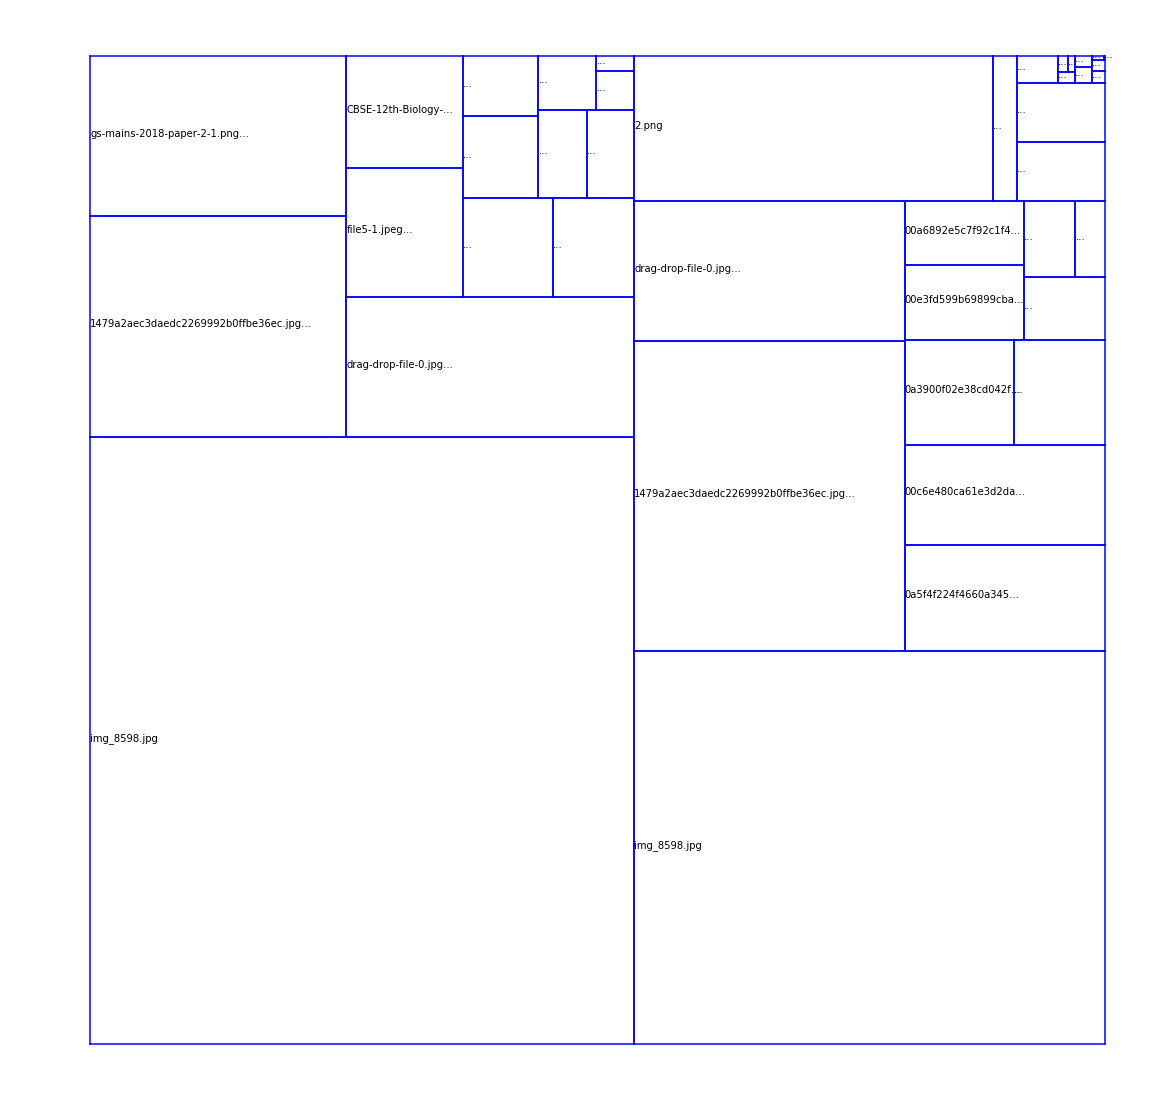

In [21]:
path = "<path>"
dataset, sum_size = recursively_walk(path, [], 0)

print(dataset)

side = math.sqrt(sum_size)

rectangles = []
squarify(dataset, [], side, (0, 0, side, side))

plot_rectangles(rectangles)